# **nnU-Net : The no-new-Net for automatic segmentation**


## **Introduction**

nnU-Net is an open-source tool that can effectively be used out-of-the-box, rendering state of the art segmentation and catalyzing scientific progress as a framework for automated method design. It provides an end-to-end automated pipeline, which can be trained and inferred on any medical dataset for segmentation.

nnU-Net has outperformed state-of-the-art architecture(s) in the [Medical Decathlon Challenge](http://medicaldecathlon.com/), comprising of 10 different datasets using an ensemble of the same U-Net architecture with an automated pipeline comprising of pre-processing, augmentation and post-processing. It has set a new benchmark in the field of medical image segmentation, without the need to fine tuning a new architecture for every dataset individually. The pipeline itself takes care of the hyperparameter tuning and requires no change in the network architecture to achieve start-of-the-art results.

## **Motivation**


*   Working through nnU-net has it's own hassles - manually renaming the files, putting the files in the write location, saving the data in the correct format. Each of these steps are time consuming and susceptible to human errors. Hence, this tutorial is written in a manner that will allow you to avoid the common errors.

*   The paper detailing nnU-net has a long supplementary material for reference (55 pages research paper). We want to save your worthy time by summarizing the internal working of the nnU-net to provide better understanding for first time users (even after working for quite sometime we had no clue what the internal workings were)

*   We have tried to provide a single notebook to run through all the necessary steps as part of getting started with nnU-net. Though nnU-net has 3 different documentations detailing all the steps, our tutorial gives brief descriptions of the parts relevant to users who just want to get started.








## **Problem Statement**


Though, nnU-Net takes care of most of the steps involved itseld, sometimes getting it up and running for a custom dataset which is not in format mentioned [here](https://github.com/prateekgupta891/nnUNet/blob/master/documentation/setting_up_paths.md) is difficult. Training the system on a colab notebook is again a challenge, as it requires a lot of manual steps. This tutorial will run you through all the necessary steps required to train your first nnU-net model along with ways to ensure the correctness of the procedure.

## **Overview of this tutorial :**

1. Introduces the nnU-Net framework
2. One-stop tutorial to train and test with different datasets 
3. Colab Notebook Based Tutorial (will work for local machines too).
4. Folder creation, command execution from particular folder location done by the code.
5. How to ingest the SCGM Challenge Dataset to the nnUNet pipeline.
6. Input and Inference Visualization

## **nnUNet Complete Work Flow**

![nnUNet Complete WorkFlow](https://raw.githubusercontent.com/prateekgupta891/nnUNet/master/nnunet_complete_workflow.png)


The nnU-Net pipeline uses heuristic rule to determine the data-dependent hyperparamters, known as the "data fingerprint", to ingest the training data. The blueprint parameters ( loss function, optimizer,architecture) and inferred parameters ( image resampling, normalization, batch and patch size) along with the data fingerprint generate pipeline fingerprints. Pipeline fingerprints produce network training for 2D, 3D and 3D-Cascade U-Net using the hyperparameters determined so far. The ensemble of different network configuration(s), along with post-processing determines the best average Dice coefficient for the training data. The best configuration will then be used to produce the predictions for the test data. Details about individual component are described below.

### **1. Dataset Fingerprint** 

It contains a set of heuristic rules to infer data-dependent hyperparamters of the pipeline. 


*   Image size (i.e. number of voxels per spatial dimension) before and after cropping image
*   Image Spacing (i.e. physical size of the voxels)
*   Modalities (from metadata)
*   Number of classes for all images and total number of training cases


### **2. Blueprint Parameters** 

**a. Architecture Template** 

*  nnU-Net architecture closely follows the original U-Net and has recently proposed variations such as residual connection, attention mechanisms, squeeze and excitation, and dilated convolutions. 

*  Prefers large patch size rather than batch size.

**b. Training Schedule**
 
*  100 epochs; one epoch defined as iteration over 250 minibatches, 

*  Stochastic gradient descent with Nestrov momentum,
*  Loss is the combination of cross-entropy and dice loss.
*  Oversampling to handle class imbalance
*  *Data Augmentation :*   rotation, scaling, guassian noise, guassian blur, brightness, contrast, simulation of low resolution and gamma resolution.

**c. Inference**

*  Images are predicted with a sliding window approach, where the window size equals the patch size used during training. Adjacent predictions overlap by half the size of a patch.

*  To suppress stitching artifacts and reduce the influence of positions close to the borders, a Gaussian importance weighing is applied, increasing the weight of the center voxels in the softmax aggregation.


### **3. Inferred Parameters**

**a. Intensity Normalization :** 
* Z-scoring for all modalities except CT.
* For CT, it follows a global normalization scheme, which uses 0.5 and 99.5 percentiles  of the foreground voxels for clipping.

**b. Resampling :** 
* To cope up with the heterogeneity in medical domain,
* Resamples all images to same target spacing using either third order spline, linear or nearest neighbor interpolation.

**c. Adaptation of network topology, patch size and batch size :** The network topology for all U-Net configurations is chosen on the basis of the median image size after resampling as well as the target spacing the images were resampled to.

**d. Initialization :** The patch size is initialized as the median image shape after resampling.

**e. Architecture Topology:** 
* The architecture is configured by determining the number of downsampling operations, performed until the feature map is reduced to 4 voxels or feature map space become anisotropic. 
* High resolution axes are downsampled separately until their resolution is within factor 2 of the lower resolution axis.
* Each axis is downsampled individually, until the feature map constraints are triggered. 
* The default kernel size for convolutions is 3×3×3 and 3×3 for 3D U-Net and 2D U-Net, respectively.


### **4. Emperical Parameters**

**a. Ensembling and selection of U-Net configuration(s) :** 
* Automatically ensembles based on average foreground Dice coefficient computed via Cross-validation on training data to use for inference 
* **Configuration model(s):** Single models (2D, 3D fullres, 3D lowres or  fullres U-Net of the cascade) or an ensemble of any two of these configurations. 
* Models are ensembled by averaging softmax probabilities.

**b. Postprocessing:** Connected component-based postprocessing is used.
All foreground classes are treated as one component, to improve the average foreground Dice coefficient and if it does not reduce the Dice coefficient for any of the classes, then nnU-Net builds on the outcome of this step and decides whether the same procedure should be performed for individual classes.

## **Different U-Net configurations** 

1.   **2D U-Net**
2.   **3D U-Net Full Resolution**
3.   **3D U-Net Cascaded :** The first U-Net operates on downsampled images and the second is trained to refine the segmentation maps created by the former at full resolution.


![U-Net Network Architecure](https://raw.githubusercontent.com/prateekgupta891/nnUNet/master/nnUNet_architecture2.png)
**Figure :** for illustratation purposes. network architecture for ACDC dataset, from Medical Decathlon taken from Paper 1 mentioned below. Filters and no. of channels will remain same for any dataset. 

### **About the Spinal Cord Grey Matter Challenge**

[SCGM Challenge](http://niftyweb.cs.ucl.ac.uk/program.php?p=CHALLENGE), has a collection of healthy spinal cord images collected at 4 different sites. As part of the challenge, you need to automatically or semi-automatically segment the anatomical MR Images into background class (as 0) and grey matter class (as 1). Algorithms will be evaluated against manual segmentations from four trained raters (one from each site) in terms of segmentation accuracy and precision.
Predicted images must be saved in NIFIT format, with same space and resolution as the provided data. 

**Note:** Training images are labelled for Background class as (0), Grey Matter class as (1) and White Matter class as (2).

### **Major Sections:** 
Train a nnUNet model for the Spinal Cord Grey Matter Segmentation Dataset and infer results . Same approach can be applied on other datasets, with  dataset specific modifications.




1. [Setup](#setup)    *(Always,CPU, GPU)*

2. [Cloning the Repo's](#clone) *(One-time, CPU, GPU)*

3. [Install and import libraries](#libraries) *(Everytime, CPU, GPU)*

4. [Structure Dataset Folder](#folder_structure) *(Evertyime, CPU, GPU)*

5. [Environment Variables](#env_variables) *(Everytime, CPU, GPU)*

6. [Unzip, Rename, Train and Test Set](#dataset_setup) *(One-time, CPU, GPU)*

7. [Dataset verification](#dataset_verify) *(One-time, Optional, CPU, GPU)*

8. [Dataset Visualization](#data_visual) *(CPU,GPU)*

9. [Training Code](#train) *(GPU only)*

10. [Inference Code](#infer) *(GPU only)*

11. [Prediction Visualization](#predict_visual) *(CPU,GPU)*

12. [Submit Code for SCGM](#submit) *(Optional, CPU, GPU)*


**Note:** For training and inference, you have to run through steps 1,3,4 everytime for colab users. For local machines, installing libraries and setting up environment variables again is not necessary.


**Papers:**

1) nnU-Net: Self-adapting Framework for U-Net-Based Medical Image Segmentation [(arxiv)](https://arxiv.org/pdf/1809.10486.pdf)

2) Automated Design of Deep Learning Methods for Biomedical Image Segmentation [(arxiv)](https://arxiv.org/pdf/1904.08128.pdf)

**Github repository:**

1) [Orginal Repository](https://github.com/MIC-DKFZ/nnUNet) - regularly maintained and changed by the authors.

2) [Forked Repository](https://github.com/prateekgupta891/nnUNet) - to ensure a version of nnUNet, using which this tutorial works as the original repository is constantly modified.

(**Colab users** - Preferrably use GPU runtime, but you can change to GPU runtime afterwards, as and when required)

##**1. Setup Section**

In [ ]:
#for colab users only - mounting the drive 
from google.colab import drive
drive.mount('/content/drive',force_remount = False)

In [2]:
#setup a base directory where everything will be installed - repo, dataset, libraries
#This .ipynb notebook needs to placed there as well.
import os
base_dir = '/content/drive/My Drive/Colab Notebooks'
os.chdir(base_dir)

##**2. Clone the repository**

In [ ]:
#comment after installed once
!git clone https://github.com/MIC-DKFZ/nnUNet.git
#git clone https://github.com/prateekgupta891/nnUNet.git #my forked version
!git clone https://github.com/NVIDIA/apex

## **3. Install and Import Libraries**

In [ ]:
#colab users - Do this everytime
#local machines - Once is enough
respository_dir = os.path.join(base_dir,'nnUNet')
os.chdir(respository_dir)

!pip install -e .
#(optional installation)
!pip install --upgrade git+https://github.com/nanohanno/hiddenlayer.git@bugfix/get_trace_graph#egg=hiddenlayer

os.chdir(base_dir)

(**Colab Users:** You must restart your runtime after installing the libraries.)

In [1]:
#libraries
import shutil
from collections import OrderedDict
import json
import numpy as np

#visualization of the dataset
import matplotlib.pyplot as plt
import nibabel as nib


#for colab users only - keep the base directory same as above
import os
base_dir = "/content/drive/My Drive/Colab Notebooks"
repository_dir = os.path.join(base_dir,'nnUNet')
os.chdir(base_dir)

In [ ]:
if os.getcwd()==base_dir:
    
    print('We are in the correct directory')
else:
    print("Run set base directory step again, then check to verify.")

## **4. Dataset Folder Structure**

In [3]:
def make_if_dont_exist(folder_path,overwrite=False):
    """
    creates a folder if it does not exists
    input: 
    folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder 
    """
    if os.path.exists(folder_path):
        
        if not overwrite:
            print(f'{folder_path} exists.')
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      os.makedirs(folder_path)
      print(f"{folder_path} created!")






**Custom Task Id starts at 101,** to ensure that there will be no conflicts with downloaded pretrained models.



```
Task Naming Convention: Task[Task Id]_[Task Name] eg. Task101_SCGM
```



In [100]:
task_name = 'Task101_SCGM' #change here for different task name
nnunet_dir = "nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name = os.path.join(nnunet_dir,task_name)
train_image_dir = os.path.join(task_folder_name,'imagesTr')
train_label_dir = os.path.join(task_folder_name,'labelsTr')
test_dir = os.path.join(task_folder_name,'imagesTs')
main_dir = os.path.join(base_dir,'nnUNet/nnunet')

In [ ]:

make_if_dont_exist(task_folder_name,overwrite = False)
make_if_dont_exist(train_image_dir)
make_if_dont_exist(train_label_dir)
make_if_dont_exist(test_dir,overwrite= False)
make_if_dont_exist(os.path.join(main_dir,'nnunet_trained_models'))

## **5.Environment Variables**

In [6]:
os.environ['nnUNet_raw_data_base'] = os.path.join(main_dir,'nnUNet_raw_data_base')
os.environ['nnUNet_preprocessed'] = os.path.join(main_dir,'preprocessed')
os.environ['RESULTS_FOLDER'] = os.path.join(main_dir,'nnUNet_trained_models')

**Colab Users:** Everytime you re-run or restart your kernel always run until this point.

## **About the Dataset**

## **6. Unzip, Rename, Train and Test Set**


**(Manual Task)** Get the train and test data in zip form and place it 
 in the /nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data folder.

Apply to get Spinal Cord Grey Matter Challenge [Dataset](http://cmictig.cs.ucl.ac.uk/niftyweb/challenge/).



Code will take care of the following:

1. Unzip train and test files

2. Rename the train images and labels to match and placing in respective directories.

3. Put testing data in the folder and remove text files

4. Add modality at the end of each file, as nnU-net can train on multiple modalities together

5. Create dataset.json 

**Note:** For a new dataset, you may need to do few changes for training. Also, nnUNet works with .nii.gz files only. 

In [ ]:
def copy_and_rename(old_location,old_file_name,new_location,new_filename,delete_original = False):

    shutil.copy(os.path.join(old_location,old_file_name),new_location)
    os.rename(os.path.join(new_location,old_file_name),os.path.join(new_location,new_filename))
    if delete_original:
        os.remove(os.path.join(old_location,old_file_name))


In [ ]:
os.chdir(task_folder_name)
if os.path.isfile('training-data-gm-sc-challenge-ismrm16-v20160302b.zip'):
    print(f'Training file for exists')
else:
    print('Training file for SCGM Challenge is not present in the directory')

if os.path.isfile('test-data-gm-sc-challenge-ismrm16-v20160401.zip'):
    print('Testing file for SCGM Challenge exists')
else:
    print('Testing file for SCGM Challenge is not present in the directory')
os.chdir(base_dir)

In [ ]:
#unzipping in nnUNet_raw folder the training data
os.chdir(task_folder_name)
!unzip training-data-gm-sc-challenge-ismrm16-v20160302b.zip
os.chdir(base_dir)

### *Rename and Relocate*

We have 4 annotation of the same image, by different experts in the SCGM Challenge. *( Image , Ann1 )* and *( Image , Ann2 )* can be considered as a different image and label pairs. Hence, 4 copies of the training .nii.gz file is created with its mapping to the respective label name.

In [ ]:
#putting training images into folder

mask_count = 4 #change if more mask is available

for file in os.listdir(task_folder_name):
    
    if file.endswith('.nii.gz'):
        if file.find('mask')!=-1:
            #putting mask
            shutil.move(os.path.join(task_folder_name,file),train_label_dir)
        else:
            #making 4 copies
            for mask in range(1,mask_count+1):
                new_filename = file[:file.find('-image')] + '-mask-r' + str(mask) + '.nii.gz'
                if mask==mask_count:
                    copy_and_rename(task_folder_name,file,train_image_dir,new_filename,delete_original = True)
                else:
                    copy_and_rename(task_folder_name,file,train_image_dir,new_filename)
    #removing all other files installed due to the unzip
    elif file.endswith('.txt'):
        os.remove(os.path.join(task_folder_name,file))
    

### *Verification*

In [ ]:
train_files = os.listdir(train_image_dir)
label_files = os.listdir(train_label_dir)
print("train image files:",len(train_files))
print("train label files:",len(label_files))
print("Matches:",len(set(train_files).intersection(set(label_files))))

#should be equal to 160 for SCGM Challenge

In [ ]:
#unzip the testing files in nnUNet_raw folder
os.chdir(task_folder_name)
!unzip test-data-gm-sc-challenge-ismrm16-v20160401.zip
os.chdir(base_dir)

In [ ]:
for file in os.listdir(task_folder_name):

    if file.endswith('.nii.gz'):
        #putting mask
        shutil.move(os.path.join(task_folder_name,file),test_dir)
    
    #removing all other files installed due to the unzip
    elif file.endswith('.txt'):
        os.remove(os.path.join(task_folder_name,file))

In [ ]:
print("Testing files:",len(os.listdir(test_dir)))
print(test_dir)
#for spinal cord dataset testing files needs to be equal to 40.

In [ ]:
#renaming to add the modality for SCGM there is only one modality 
#images should be added with 0000
#can be skipped if modality is already mentioned
#re-write for multiple modalities

def check_modality(filename):
    """
    check for the existence of modality
    return False if modality is not found else True
    """
    end = filename.find('.nii.gz')
    modality = filename[end-4:end]
    for mod in modality: 
        if not(ord(mod)>=48 and ord(mod)<=57): #if not in 0 to 9 digits
            return False
    return True

def rename_for_single_modality(directory):
    
    for file in os.listdir(directory):
        
        if check_modality(file)==False:
            new_name = file[:file.find('.nii.gz')]+"_0000.nii.gz"
            os.rename(os.path.join(directory,file),os.path.join(directory,new_name))
            print(f"Renamed to {new_name}")
        else:
            print(f"Modality present: {file}")

rename_for_single_modality(train_image_dir)
rename_for_single_modality(test_dir)

### Creating **dataset.json**

In [ ]:
overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = task_name
    json_dict['description'] = "Spinal Cord Grey Matter Segmenation Challenge"
    json_dict['tensorImageSize'] = "3D"
    json_dict['reference'] = "see challenge website"
    json_dict['licence'] = "see challenge website"
    json_dict['release'] = "0.0"

    #you may mention more than one modality
    json_dict['modality'] = {
        "0": "MRI"
    }
    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "0": "background",
        "1": "grey matter",
        "2": "white matter"
    }
    
    train_ids = os.listdir(train_label_dir)
    test_ids = os.listdir(test_dir)
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)

    #no modality in train image and labels in dataset.json 
    json_dict['training'] = [{'image': "./imagesTr/%s" % i, "label": "./labelsTr/%s" % i} for i in train_ids]

    #removing the modality from test image name to be saved in dataset.json
    json_dict['test'] = ["./imagesTs/%s" % (i[:i.find("_0000")]+'.nii.gz') for i in test_ids]

    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

##**7. Dataset Verification**

In [ ]:
#running it from the experiment_planning folder to verify the path settings
os.chdir(main_dir)
!python experiment_planning/nnUNet_plan_and_preprocess.py -t 101 --verify_dataset_integrity
os.chdir(base_dir)

## **8. Dataset Visualization** 

### Train Data

(320, 320, 5) (320, 320, 5)
2 5


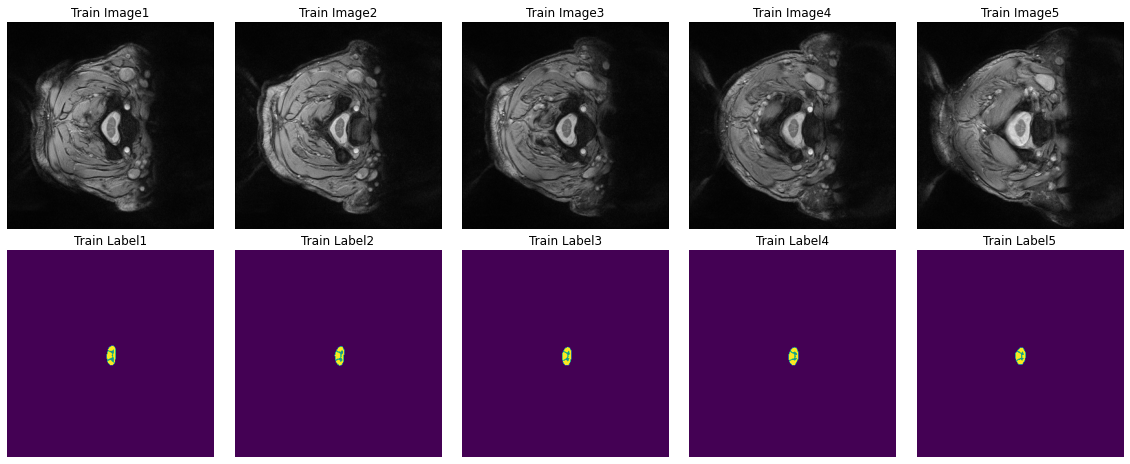

In [94]:
#visualizing some of the training images and labels
# (re-run to see random pick-ups)
# only maximum of first 5 slices are plotted
train_img_name = os.listdir(train_image_dir)[np.random.randint(0,160)]
train_img = np.array(nib.load(os.path.join(train_image_dir,train_img_name)).dataobj)[:,:,:5]
train_label_name = train_img_name[:train_img_name.find('_0000.nii.gz')]+'.nii.gz'
train_label = np.array(nib.load(os.path.join(train_label_dir,train_label_name)).dataobj)[:,:,:5]

print(train_img.shape,train_label.shape)

max_rows = 2
max_cols = train_img.shape[2]

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))
for idx in range(max_cols):
    axes[0, idx].axis("off") 
    axes[0, idx].set_title('Train Image'+str(idx+1))
    axes[0 ,idx].imshow(train_img[:,:,idx], cmap="gray")
for idx in range(max_cols):    
    axes[1, idx].axis("off")
    axes[1, idx].set_title('Train Label'+str(idx+1))
    axes[1, idx].imshow(train_label[:,:,idx])

plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()


**Note:** In predicted image, yellow color represents white Matter and green-ish color represents grey matter.

### Test Data

(320, 320, 5)


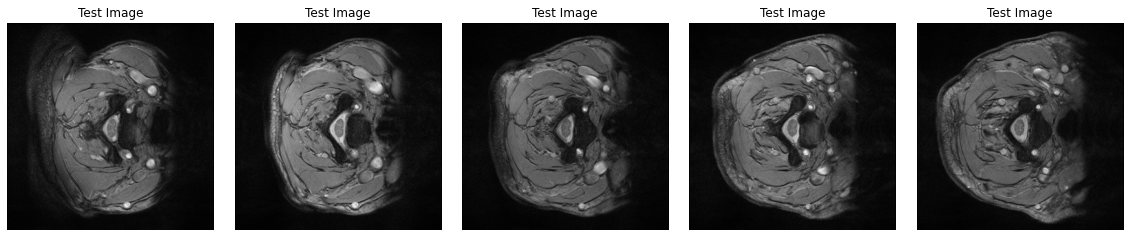

In [96]:
#visualizing some of the test images
# (re-run to see random pick-ups)
# only maximum of first 5 slices are plotted

test_img_name = os.listdir(test_dir)[np.random.randint(0,40)]
test_img = np.array(nib.load(os.path.join(test_dir,test_img_name)).dataobj)[:,:,:5]

print(test_img.shape)

max_cols = test_img.shape[2]
max_rows = 1

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,20))
for idx in range(max_cols):
    axes[ idx].axis("off") 
    axes[ idx].set_title('Test Image')
    axes[ idx].imshow(test_img[:,:,idx], cmap="gray")
    
    
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()


## **9. Training Code**

nnU-Net stores a checkpoint every 50 epochs. If you need to continue a previous training, just add a -c to the training command.

**Generic Training Commands:**

    nnUNet_train CONFIGURATION TRAINER_CLASS_NAME TASK_NAME_OR_ID FOLD (additional options)


**For 2D:**   ``` nnUNet_train 2d nnUNetTrainerV2 TaskXXX_MYTASK FOLD```

**For 3D Full resolution:** ```    nnUNet_train 3d_fullres nnUNetTrainerV2 TaskXXX_MYTASK FOLD```

**For Cascaded 3D:** 

First Run lowres: ```   nnUNet_train 3d_lowres nnUNetTrainerV2 TaskXXX_MYTASK FOLD``` 

Then Run fullres: ``` nnUNet_train 3d_cascade_fullres nnUNetTrainerV2CascadeFullRes TaskXXX_MYTASK FOLD ```




In [ ]:
#colab users - mandatory
#local machine - once is sufficient
os.chdir('apex')
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
os.chdir(base_dir)

Training for 3D fullres with Trainer V2 and for Fold 0.

In [ ]:
os.chdir(main_dir)
!nnUNet_train 3d_fullres nnUNetTrainerV2 101 0 -c
os.chdir(base_dir)

##**10. Inference Code**
```nnUNet_find_best_configuration``` will print inference commands you need to use. The easiest way to run inference is to simply use these commands.


For each of the desired configurations, run:
```
nnUNet_predict -i INPUT_FOLDER -o OUTPUT_FOLDER -t TASK_NAME_OR_ID -m CONFIGURATION --save_npz
```
Only specify --save_npz if you intend to use ensembling. --save_npz will make the command save the softmax probabilities alongside of the predicted segmentation masks requiring a lot of disk space.

**Note:** Please select a separate OUTPUT_FOLDER for each configuration!


In [ ]:
#optional
os.chdir(repository_dir)
!nnUNet_find_best_configuration -t 101
os.chdir(base_dir)

In [99]:
print(main_dir,)

/content/drive/My Drive/Colab Notebooks/nnUnet/nnunet


In [ ]:
result_dir = os.path.join(main_dir,'nnUNet_Prediction_Results',task_name)
make_if_dont_exist(result_dir)

team_name = 'prateek3' #make sure to change for your own team name

In [ ]:
#location where you want save your results, will be created if dont exist
os.chdir(main_dir)
!nnUNet_predict -i nnUNet_raw_data_base/nnUNet_raw_data/Task101_SCGM/imagesTs -o nnUNet_Prediction_Results/Task101_SCGM -t 101 -tr nnUNetTrainerV2 -m 3d_fullres --num_threads_preprocessing 1
os.chdir(base_dir)

If you wish to run ensembling, you can ensemble the predictions from several configurations with the following command:
```
nnUNet_ensemble -f FOLDER1 FOLDER2 ... -o OUTPUT_FOLDER -pp POSTPROCESSING_FILE
```

## **11. Prediction Visualization**

Test Image Shape:  (320, 320, 5)
Predicted Image Shape: (320, 320, 5)


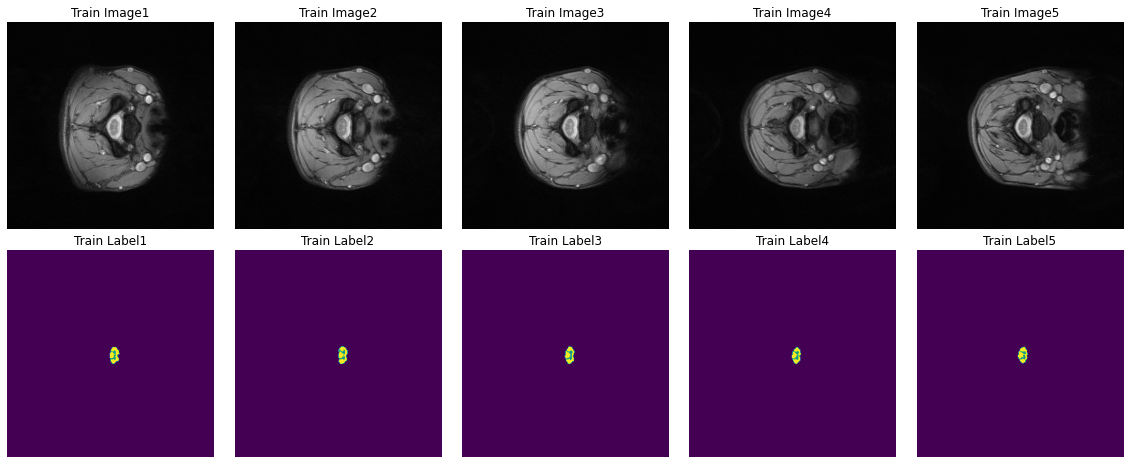

In [107]:
#visualizing the predicted results
# (re-run to see random pick-ups)
# only maximum of first 5 slices are plotted

test_img_name = os.listdir(test_dir)[np.random.randint(0,40)]
test_img = np.array(nib.load(os.path.join(test_dir,test_img_name)).dataobj)[:,:,:5]
predicted_img_name = test_img_name[:test_img_name.find('_0000.nii.gz')]+'.nii.gz'
predicted_label = np.array(nib.load(os.path.join(result_dir,predicted_img_name)).dataobj)[:,:,:5]
print('Test Image Shape: ',test_img.shape)
print("Predicted Image Shape:",predicted_label.shape)

max_rows = 2
max_cols = test_img.shape[2]

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))
for idx in range(max_cols):
    axes[0, idx].axis("off") 
    axes[0, idx].set_title('Train Image'+str(idx+1))
    axes[0 ,idx].imshow(test_img[:,:,idx], cmap="gray")
for idx in range(max_cols):    
    axes[1, idx].axis("off")
    axes[1, idx].set_title('Train Label'+str(idx+1))
    axes[1, idx].imshow(predicted_label[:,:,idx])
    
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()


## **12. SCGM submission** (optional)

While trianing, we trained the dataset to learn, **White Matter** as well as **Grey Matter**. But for the challenge we only need to predict *Gray matter* labelled as *1*, and *everything else is 0*. So we convert the labels.

Test images naming convention: **[Original test filename]-[team name].nii.gz**

In [ ]:
#specific to the submission

submission_folder = os.path.join(result_dir,'submission_folder')
make_if_dont_exist(submission_folder)

for file in os.listdir(result_dir):
    
    if file.endswith('.nii.gz'):
        
        img = nib.load(os.path.join(result_dir,file))

        img_np = np.array(img.dataobj)
        img_np[img_np==2.0] = 0.0
        img_nifti = nib.Nifti1Image(img_np,affine = np.eye(4))

        new_file = file[:file.find('image')]+team_name+'.nii.gz'
        
        nib.save(img_nifti, os.path.join(submission_folder,new_file))

        print(new_file)
        

**Test Results:**
Download the the folder, and upload with at the following [link](http://niftyweb.cs.ucl.ac.uk/program.php?p=CHALLENGE).


![picture](https://raw.githubusercontent.com/prateekgupta891/nnUNet/master/result.png)

**Note:** These results are achieved with only 10 epochs on 3D full resolution on a single fold without post-processing, and it is better than results, mentioned by SCGM Challenge website [here](http://niftyweb.cs.ucl.ac.uk/program.php?p=CHALLENGE).
Dice Score is better by 0.04 from the best results.